In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
import numpy as np
from typing import Optional

In [ ]:
def drop_path_f(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path_f(x, self.drop_prob, self.training)

In [ ]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

# 整体架构

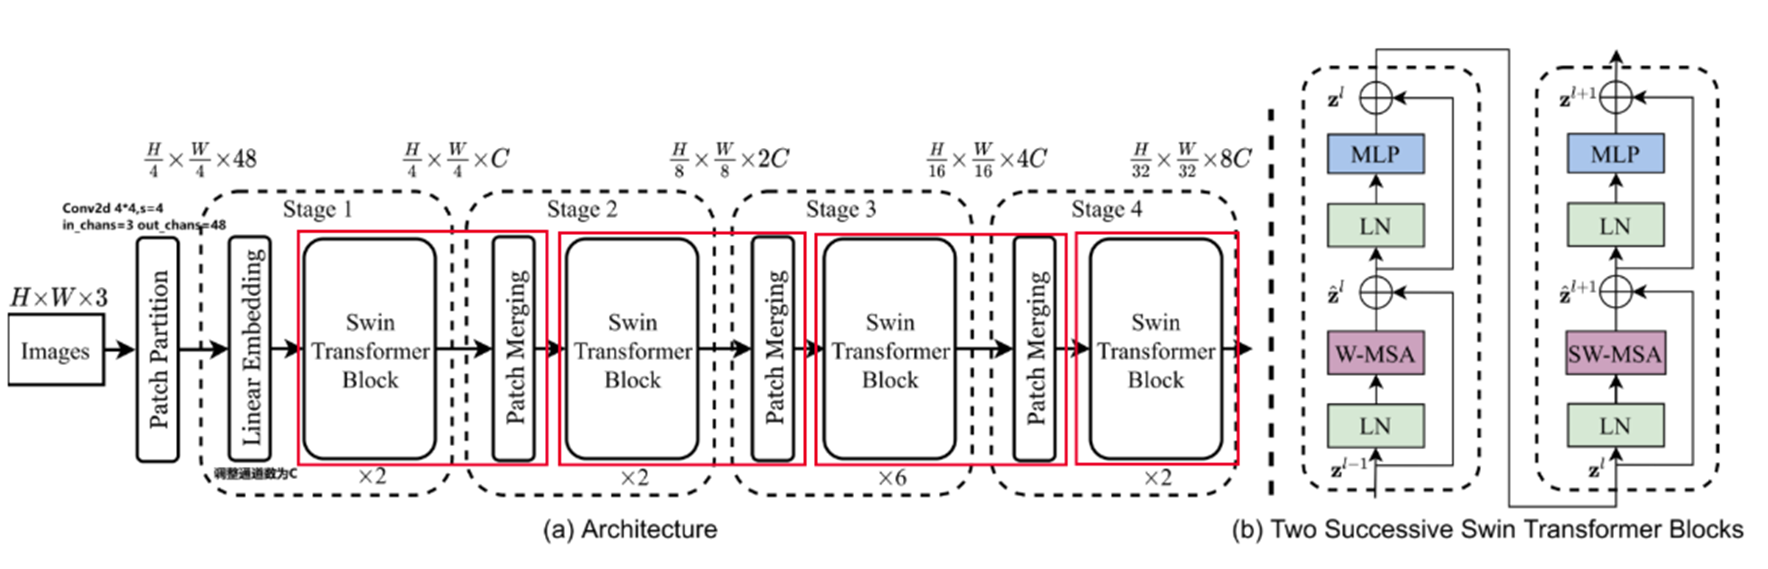

## Patch Partition和Linear Embedding

初始化方法中定义了patch大小、通道数、嵌入的维度、归一化层（可选）和使用 nn.Conv2d 来实现对输入图像的 patch 划分和 embedding。卷积核的大小和步幅都设置为 patch_size，所以每个 patch 都会被嵌入为一个向量。

前向传播过程：获取高度和宽度后进行判断，若高或宽不能被patch_size整除则进行宽向右，高向下的padding。然后直接通过一个卷积层实现Patch Partition和Linear Embeding。从维度2开始展平，将HW与C交换，最后通过Norm
。


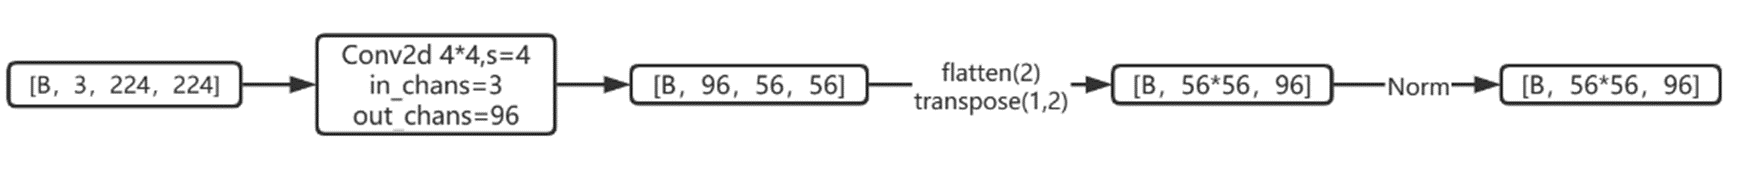

In [ ]:
class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, patch_size=4, in_c=3, embed_dim=96, norm_layer=None):
        super().__init__()
        patch_size = (patch_size, patch_size)
        self.patch_size = patch_size
        self.in_chans = in_c
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        _, _, H, W = x.shape
        # padding
        # 如果输入图片的H，W不是patch_size的整数倍，需要进行padding
        pad_input = (H % self.patch_size[0] != 0) or (W % self.patch_size[1] != 0)
        if pad_input:
            # to pad the last 3 dimensions,
            # (W_left, W_right, H_top,H_bottom, C_front, C_back)
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1],
                          0, self.patch_size[0] - H % self.patch_size[0],
                          0, 0))

        # 下采样patch_size倍
        x = self.proj(x)
        _, _, H, W = x.shape
        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C]
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, H, W

## Patch Merging

Patch Merging会将每个2x2的相邻像素划分为一个patch，然后将每个patch中相同位置（同一颜色）像素给拼在一起就得到了4个特征图。接着将这四个特征图在深度方向进行concat拼接，然后在通过一个LayerNorm层。最后通过一个全连接层在特征图的深度方向做线性变化，将特征图的深度由C变成C/2。

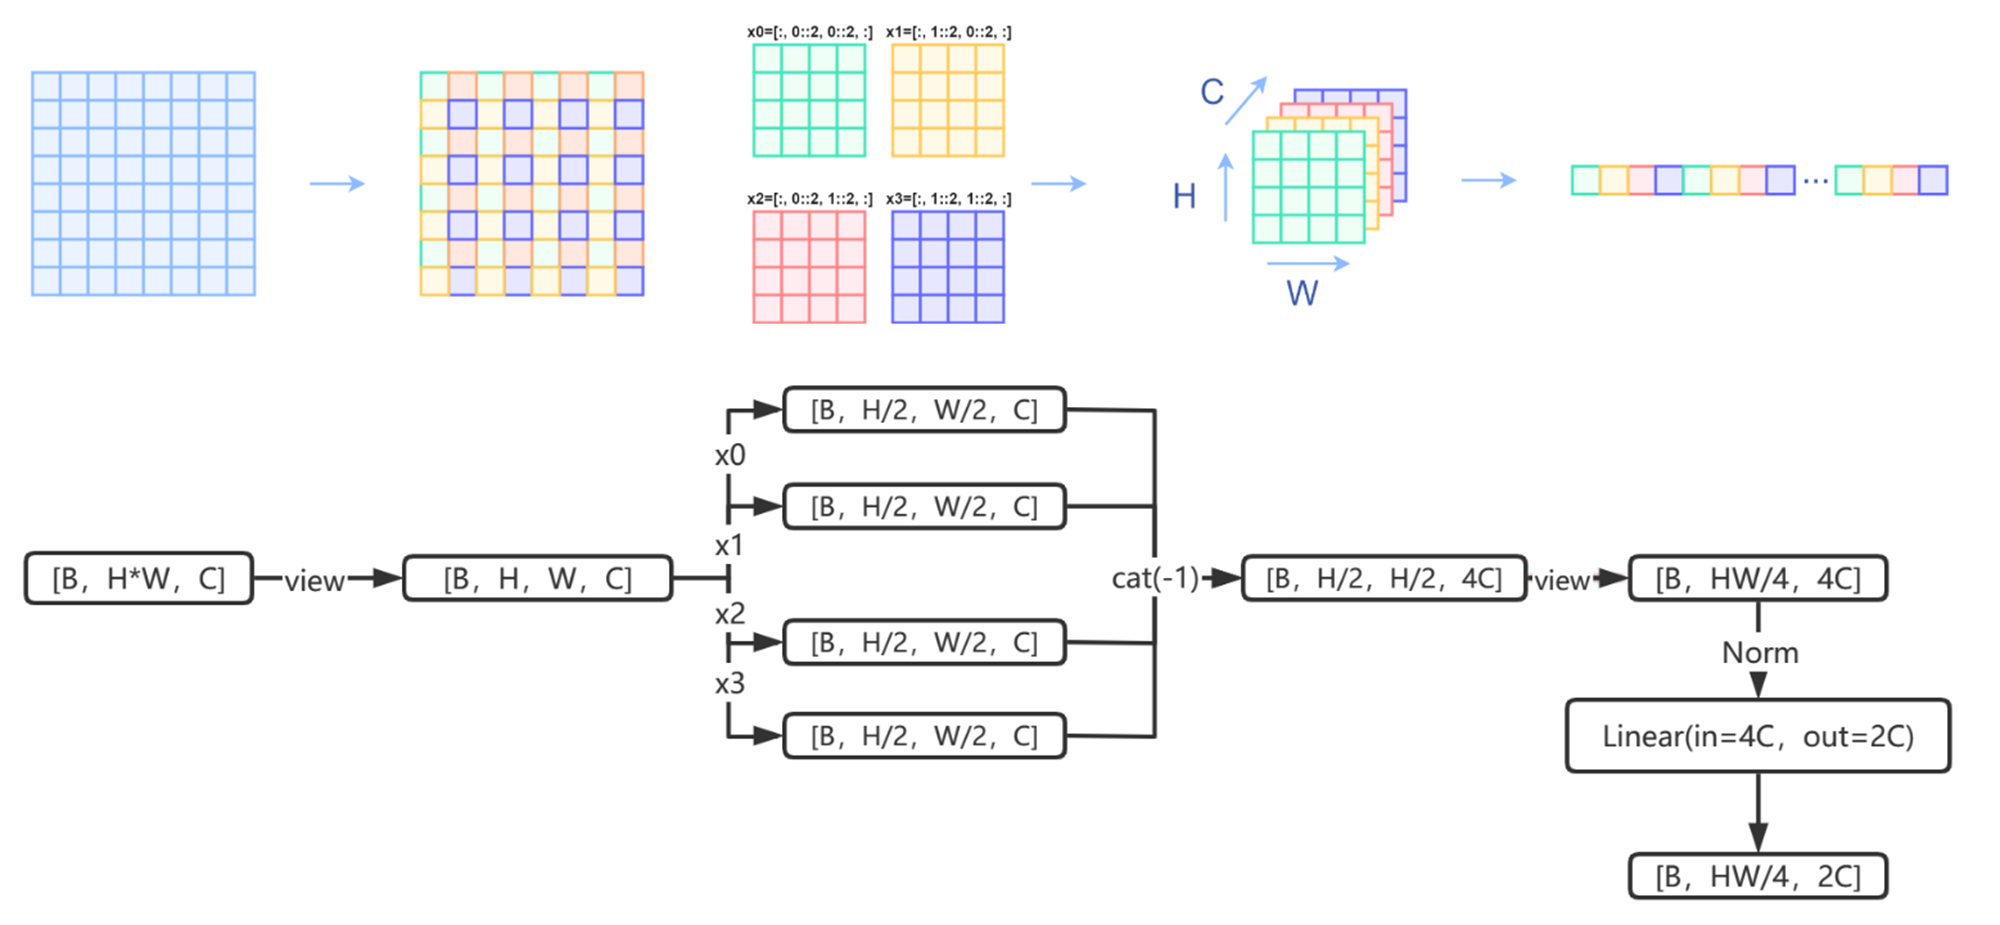

In [ ]:
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x, H, W):
        """
        x: B, H*W, C
        """
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)

        # padding
        # 如果输入feature map的H，W不是2的整数倍，需要进行padding
        pad_input = (H % 2 == 1) or (W % 2 == 1)
        if pad_input:
            # to pad the last 3 dimensions, starting from the last dimension and moving forward.
            # (C_front, C_back, W_left, W_right, H_top, H_bottom)
            # 注意这里的Tensor通道是[B, H, W, C]，所以会和官方文档有些不同
            x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))

        x0 = x[:, 0::2, 0::2, :]  # [B, H/2, W/2, C]
        x1 = x[:, 1::2, 0::2, :]  # [B, H/2, W/2, C]
        x2 = x[:, 0::2, 1::2, :]  # [B, H/2, W/2, C]
        x3 = x[:, 1::2, 1::2, :]  # [B, H/2, W/2, C]
        x = torch.cat([x0, x1, x2, x3], -1)  # [B, H/2, W/2, 4*C]
        x = x.view(B, -1, 4 * C)  # [B, H/2*W/2, 4*C]

        x = self.norm(x)
        x = self.reduction(x)  # [B, H/2*W/2, 2*C]

        return x

## 子组件

window partition函数是用于对张量划分窗口，指定窗口大小，将原本的张量从 B H W C, 划分成 num_windows * B, window_size, window_size, C，其中 num_windows = H * W / window_size * window_size，即窗口的个数。而window reverse函数则是对应的逆过程。

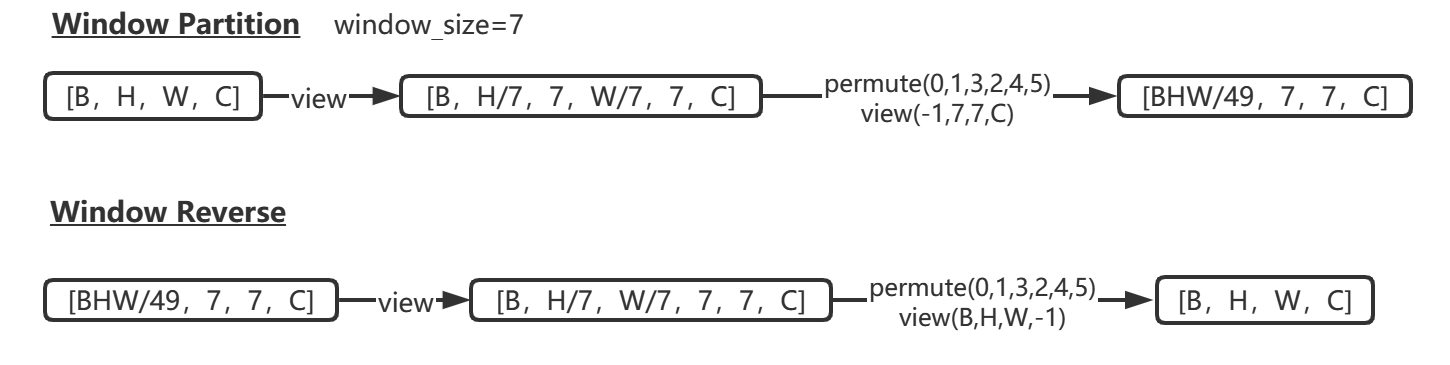

In [ ]:
def window_partition(x, window_size: int):
    """
    将feature map按照window_size划分成一个个没有重叠的window
    Args:
        x: (B, H, W, C)
        window_size (int): window size(M)

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    # permute: [B, H//Mh, Mh, W//Mw, Mw, C] -> [B, H//Mh, W//Mh, Mw, Mw, C]
    # view: [B, H//Mh, W//Mw, Mh, Mw, C] -> [B*num_windows, Mh, Mw, C]
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size: int, H: int, W: int):
    """
    将一个个window还原成一个feature map
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size(M)
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    # view: [B*num_windows, Mh, Mw, C] -> [B, H//Mh, W//Mw, Mh, Mw, C]
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    # permute: [B, H//Mh, W//Mw, Mh, Mw, C] -> [B, H//Mh, Mh, W//Mw, Mw, C]
    # view: [B, H//Mh, Mh, W//Mw, Mw, C] -> [B, H, W, C]
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

## Window Attention

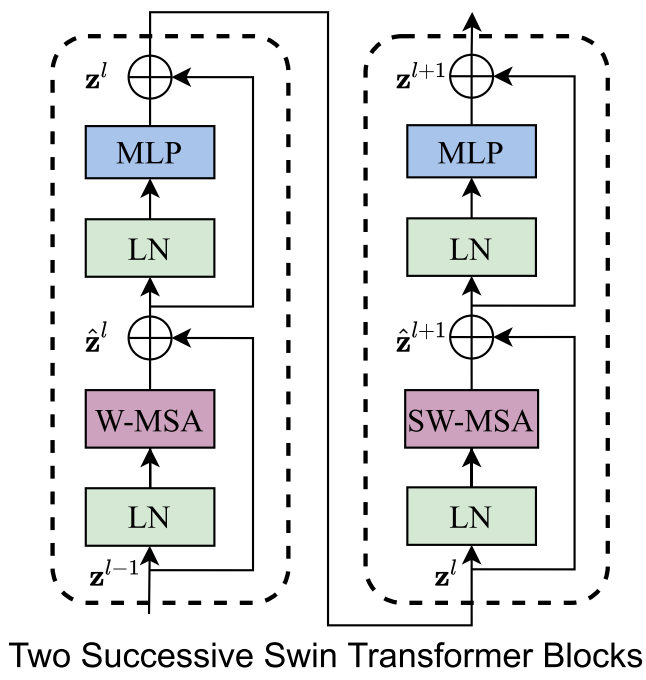

传统的 Transformer 都是**基于全局来计算注意力的**，因此计算复杂度十分高。而 Swin Transformer 则将**注意力的计算限制在每个窗口内**，其公式如下：

$$
Attention(Q,K,V)=Softmax(\frac{{QK}^T}{\sqrt d}+B)V
$$
主要区别是在原始计算 Attention 的公式中的 Q,K 时**加入了相对位置编码**。

Q,K,V.shape=[numWindows\*B, num_heads, window_size\*window_size, head_dim]，
- window_size*window_size 即 NLP 中**token**的个数
- $head\_dim=\frac{Embedding\_dim}{num\_heads}$ 即 NLP 中**token**的词嵌入向量的维度


${QK}^T$计算出来的Attention张量的形状为[numWindows\*B, num_heads, Q_tokens, K_tokens],
- Q_tokens=K_tokens=window_size*window_size

以window_size=2为例：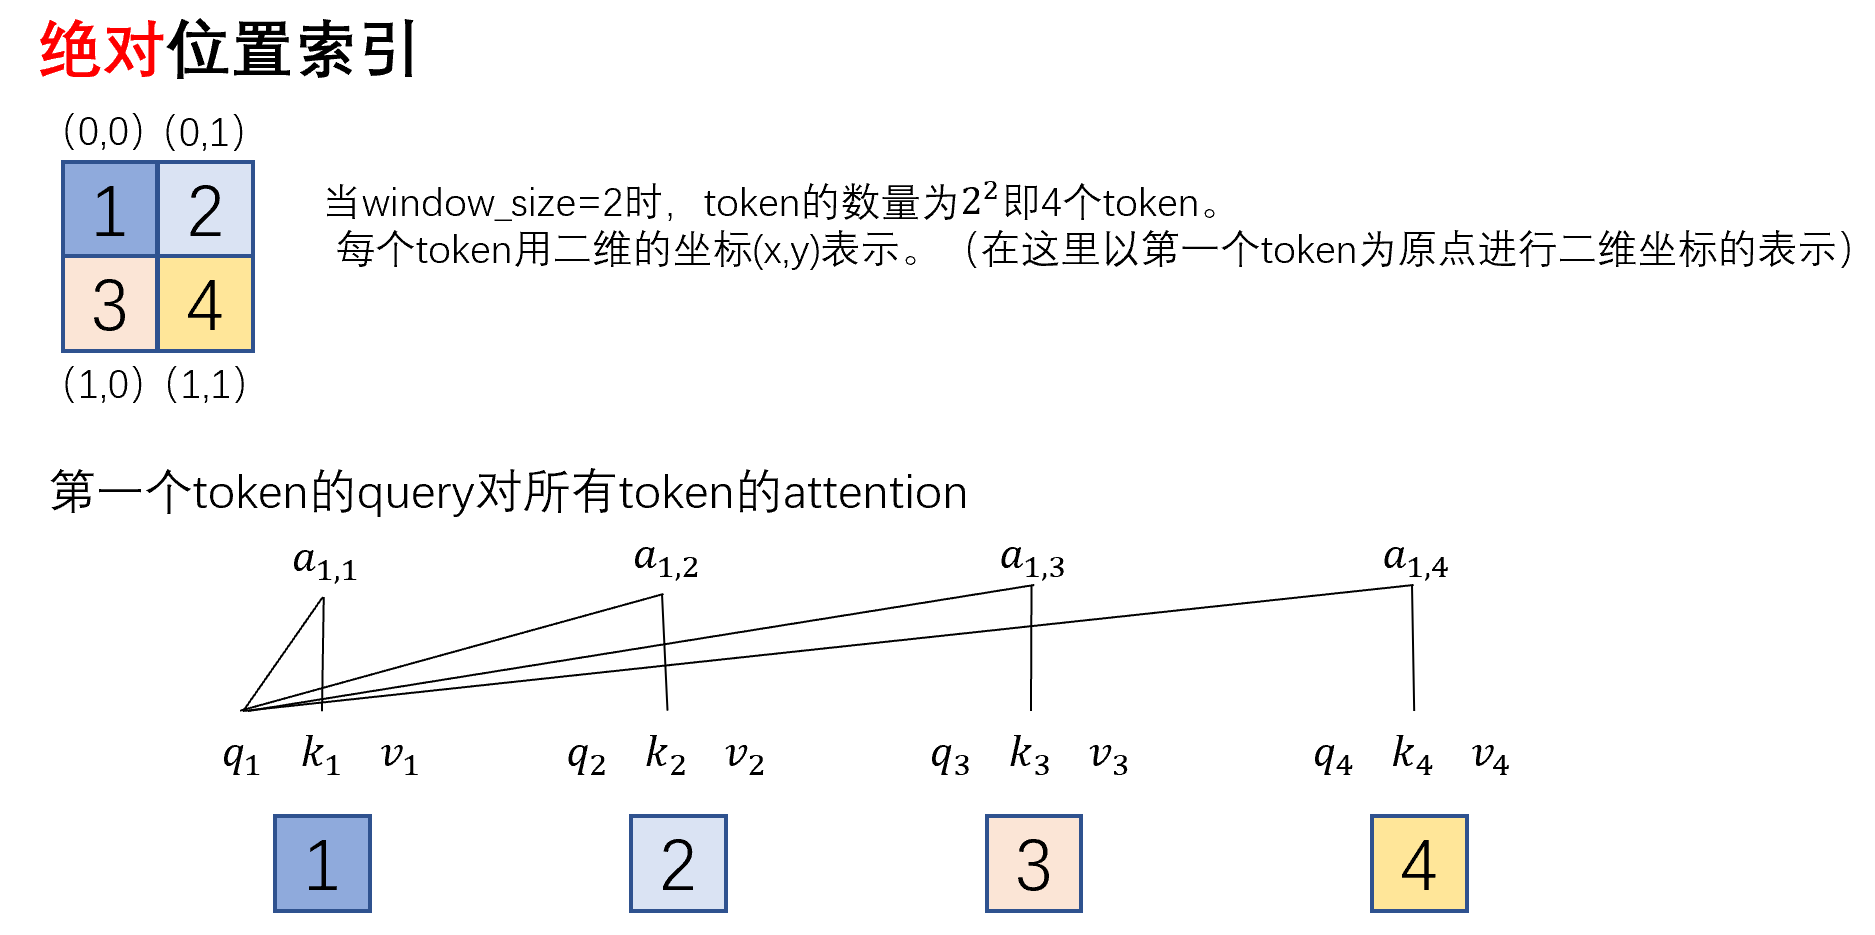

因此：${QK}^T=\left[\begin{array}{cccc}a_{11} & a_{12} & a_{13} & a_{14} \\ a_{21} & a_{22} & a_{23} & a_{24} \\ a_{31} & a_{32} & a_{33} & a_{34} \\ a_{41} & a_{42} & a_{43} & a_{44}\end{array}\right]$ 
- 第 $i$ 行表示第 $i$ 个 token 的**query**对所有token的**key**的attention。
- 对于 Attention 张量来说，**以不同元素为原点，其他元素的坐标也是不同的**

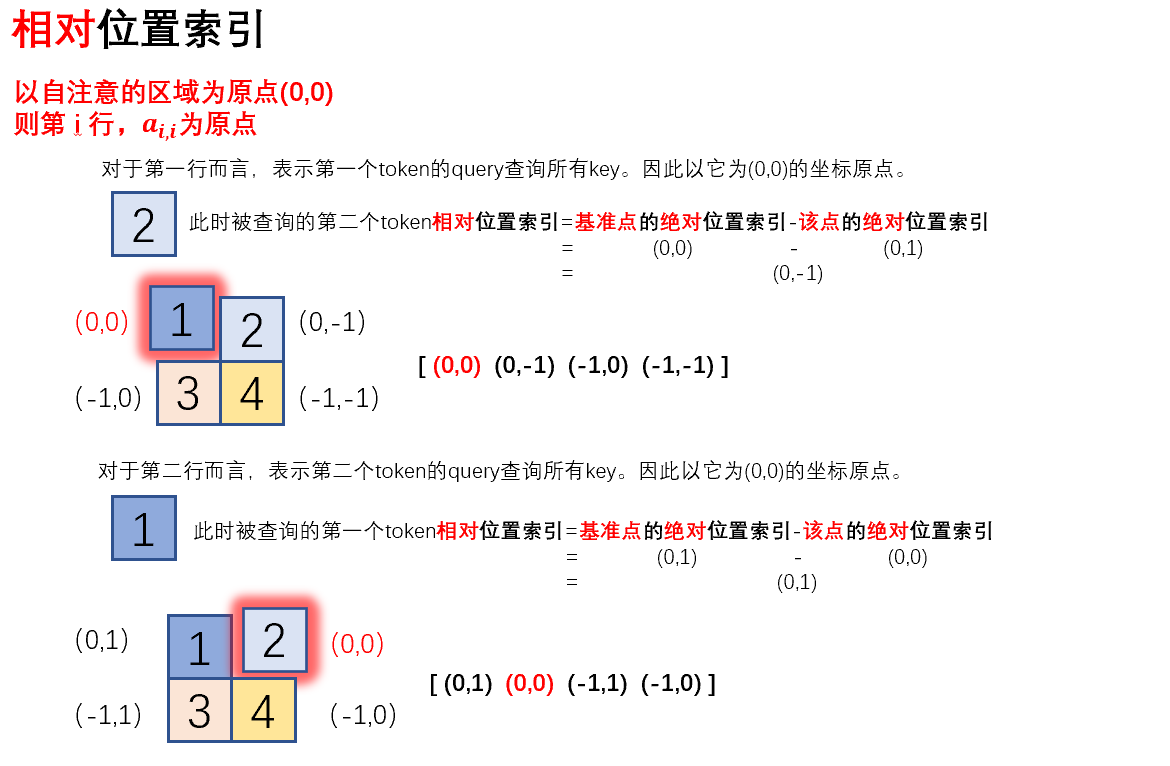

所以${QK}^T的相对位置索引=\left[\begin{array}{cccc}(0,0) & (0,-1) & (-1,0) & (-1,-1) \\ (0,1) & (0,0) & (-1,1) & (-1,0) \\ (1,0) & (1,-1) & (0,0) & (0,-1) \\ (1,1) & (1,0) & (0,1) & (0,0)\end{array}\right]$

由于最终我们希望使用一维的位置坐标x+y代替二维的位置坐标(x,y)，为了避免 (1,2) (2,1) 两个坐标转为一维时均为3，我们之后对相对位置索引进行了一些**线性变换**，使得能通过**一维**的位置坐标**唯一映射**到一个**二维**的位置坐标，详细可以通过代码部分进行理解。

首先利用torch.arange和torch.meshgrid函数生成对应的坐标，然后堆叠起来，展开为一个二维向量，利用广播机制，分别在第一和第二维插入一个维度，进行广播相减，得到 2, wh\*ww, wh\*ww的张量，

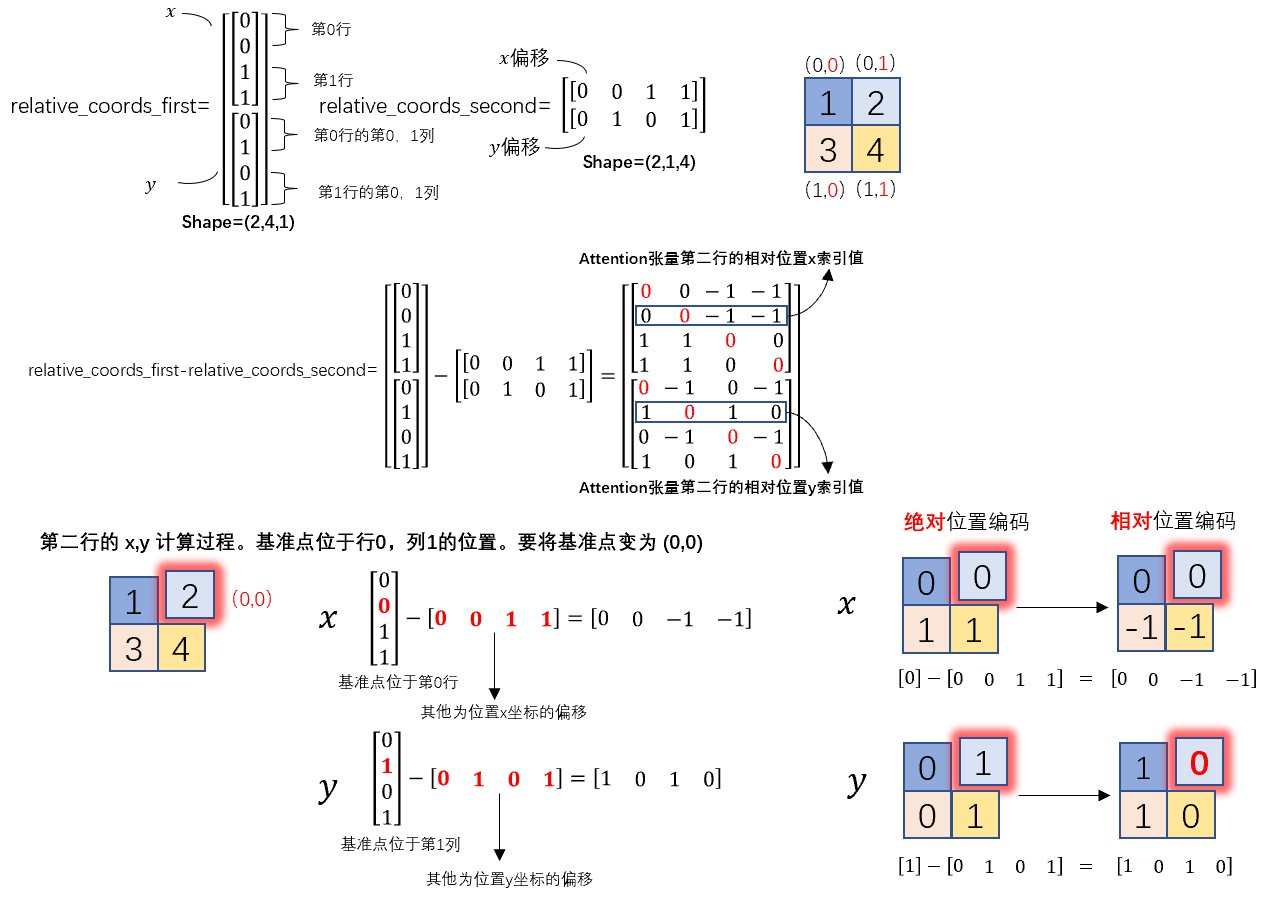

因为采取的是相减，所以得到的索引是从负数开始的，**我们加上偏移量，让其从 0 开始**。后续我们需要将其展开成一维偏移量。而对于 (1，2）和（2，1）这两个坐标。在二维上是不同的，**但是通过将 x,y 坐标相加转换为一维偏移的时候，他的偏移量是相等的**。

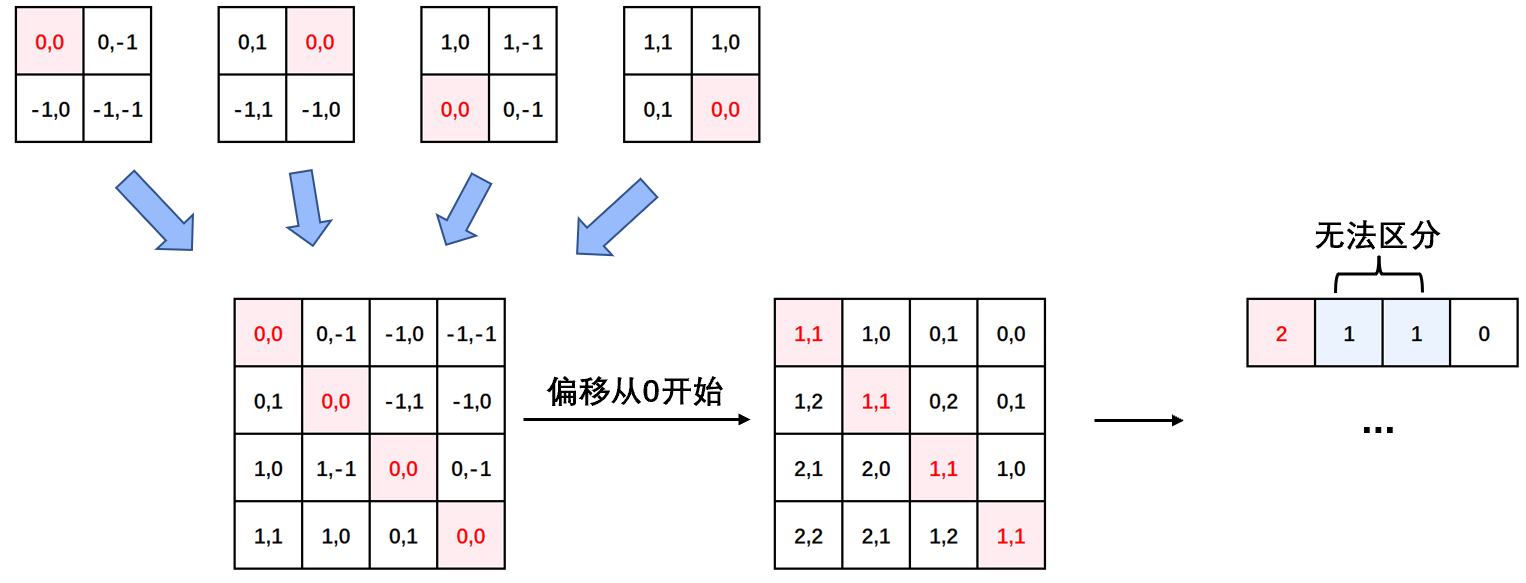

所以最后我们对其中做了个乘法操作，以进行区分

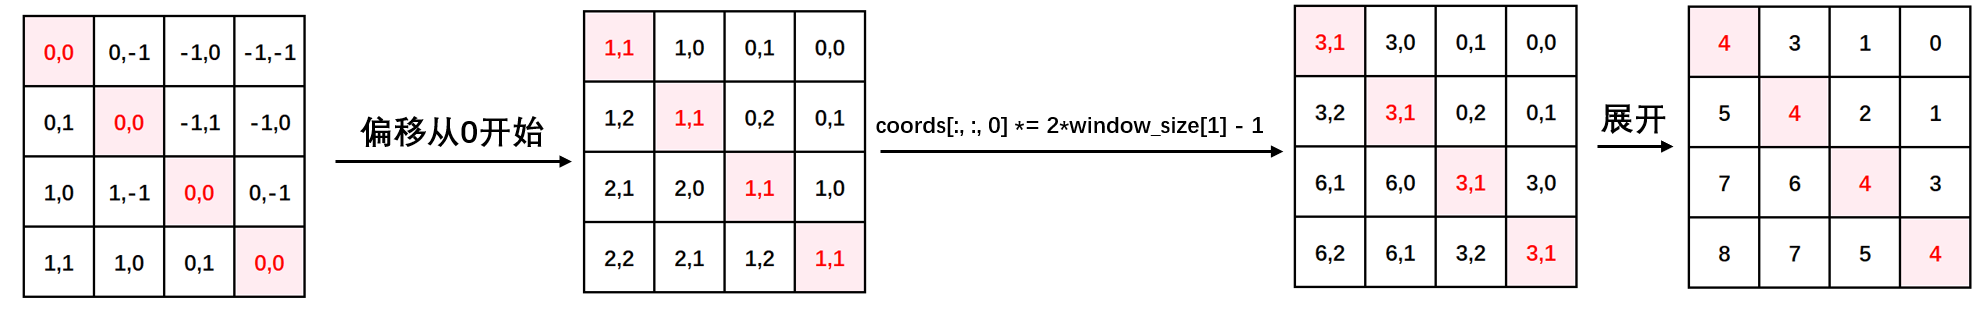

之前计算的是相对位置索引，并不是相对位置偏置参数。真正使用到的可训练参数$\hat B$是保存在**relative position bias table**表里的，这个表的长度是等于 **(2M−1) × (2M−1)** (在二维位置坐标中线性变化乘以2M-1导致)的。那么上述公式中的相对位置偏执参数B是根据上面的相对位置索引表根据查**relative position bias table**表得到的。


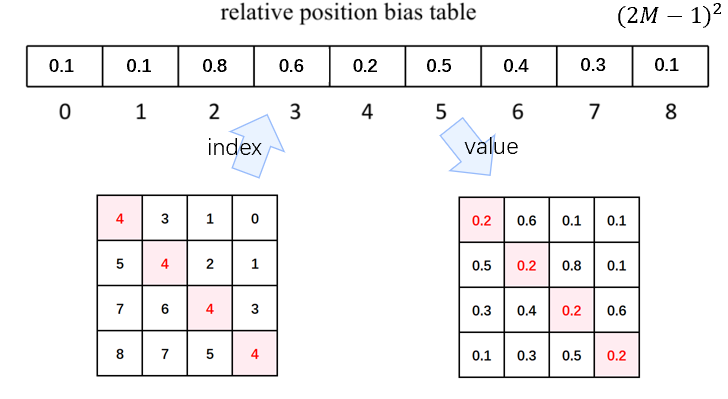

In [ ]:
class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        # dim是输入维度，
        # qk_scale就是dk
        # num_heads随着后面patch merging增加通道数，也就是embedding维数，为了让每个头接受的数据量一致，所有增加num_head
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        # 这里，如果传入dk也就是qk_sclae，那么就是根号dk；如果不传入，就是根号head_dim

        # define a parameter table of relative position bias
        # 相对位置参数
        # 就是softmax(qk^t / dk)*V + b
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        # get pair-wise relative position index for each token inside the window
        # 这里是计算相对位置的索引
        # 这个索引是个固定的，也就是不可学习的，所以最后放在register_buffer里
        # 然而，相对位置偏表B是learnable，B的索引如果与相对位置矩阵中的值对应，就要把这个索引的值放在相对位置矩阵这个值上
        # for i, value in enumerate(table):
        #     position[torch.where(position == i)] = value
        coords_h = torch.arange(self.window_size[0])  #生成对应的坐标
        coords_w = torch.arange(self.window_size[1])
        
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww 堆叠
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww 展开
        # relative_coords_first - relative_coords_second
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        # 相对位置编码以后的常规操作
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        # nn.Linear(输入特征, 输出特征，是否加入偏置)
        # 输出特征*3是为了要输出查询、键和值三个张量
        # 定义了一个线性映射层，
        self.attn_drop = nn.Dropout(attn_drop)
        # dropout的作用是随机失活
        self.proj = nn.Linear(dim, dim)
        # 映射成原来的特征大小
        self.proj_drop = nn.Dropout(proj_drop)

        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        # 下面线性变换的时候是在通道上堆叠QKV
        # N 表示序列长度(sequence length)
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)  # permute重排列
        q, k, v = qkv.unbind(0)  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))  # 把最后两个维度颠倒过来
        # patch数量也就是window大小 * window大小, window大小 * window大小

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        # for i, value in enumerate(self.relative_position_bias_table):
        #     self.relative_position_index[torch.where(self.relative_position_index == i)] = value
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            # mask 维度:  num_windows, Wh*Ww, Wh*Ww  (Wh = seq_len * seq_len)
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            # mask维度为[1, nW, 1, Mh*Mw, Mh*Mw]
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

前向传播：
- 首先输入张量形状为 [numWindows*B, window_size * window_size, C]
- 然后经过self.qkv这个全连接层后，进行 reshape，调整轴的顺序，得到形状为[3, numWindows*B, num_heads, window_size*window_size, c//num_heads]，并分配给q,k,v。
- 根据公式，我们对q乘以一个scale缩放系数，然后与k（为了满足矩阵乘要求，需要将最后两个维度调换）进行相乘。得到形状为[numWindows*B, num_heads, window_size*window_size, window_size*window_size]的attn张量
- 之前我们针对位置编码设置了个形状为(2*window_size-1*2*window_size-1, numHeads)的可学习变量。我们用计算得到的相对编码位置索引self.relative_position_index.vew(-1)选取，得到形状为(window_size*window_size, window_size*window_size, numHeads)的编码，再permute(2,0,1)后加到attn张量上
- 暂不考虑 mask 的情况，剩下就是跟 transformer 一样的 softmax，dropout，与V矩阵乘，再经过一层全连接层和 dropoutpout

# SwinTransformerBlock

初始化了一些基本参数，其中对shift_size进行判断。

前向传播过程:  

x: (B, H\* W, C)->(B, H, W, C)->padding->shift_size进行判断
- shift_size>0则为SWMSA通过torch.roll实现shifted window 操作，解决了不同窗口之间无法进行信息交流的问题。
- shift_size<0则为WMSA


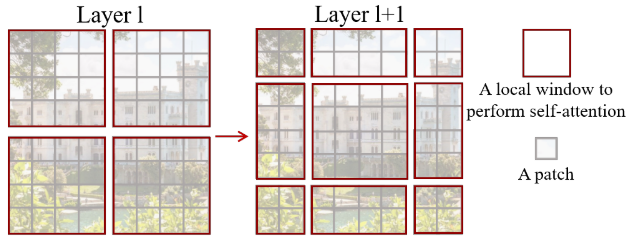

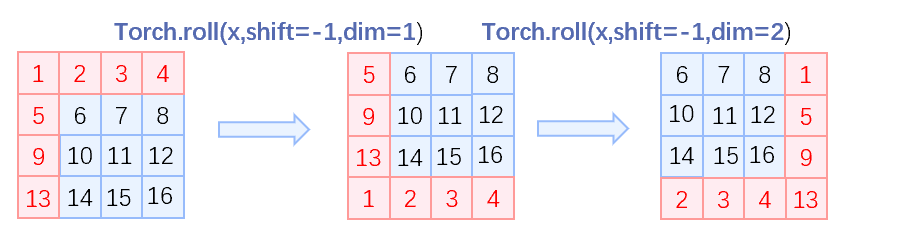


之后调用partition windows(B, H, W, C)->(nW\*B, Mh, Mw, C)->(nW\*B, Mh\*Mw, C)->在每个窗口下计算注意力->(nW\*B, Mh\*Mw, C)->(nW\*B, Mh, Mw, C)->
调用window_reverse还原为(B, H, W, C)->shift_size进行判断
- shift_size>0则为SWMSA通过torch.roll还原
- shift_size<0则为WMSA

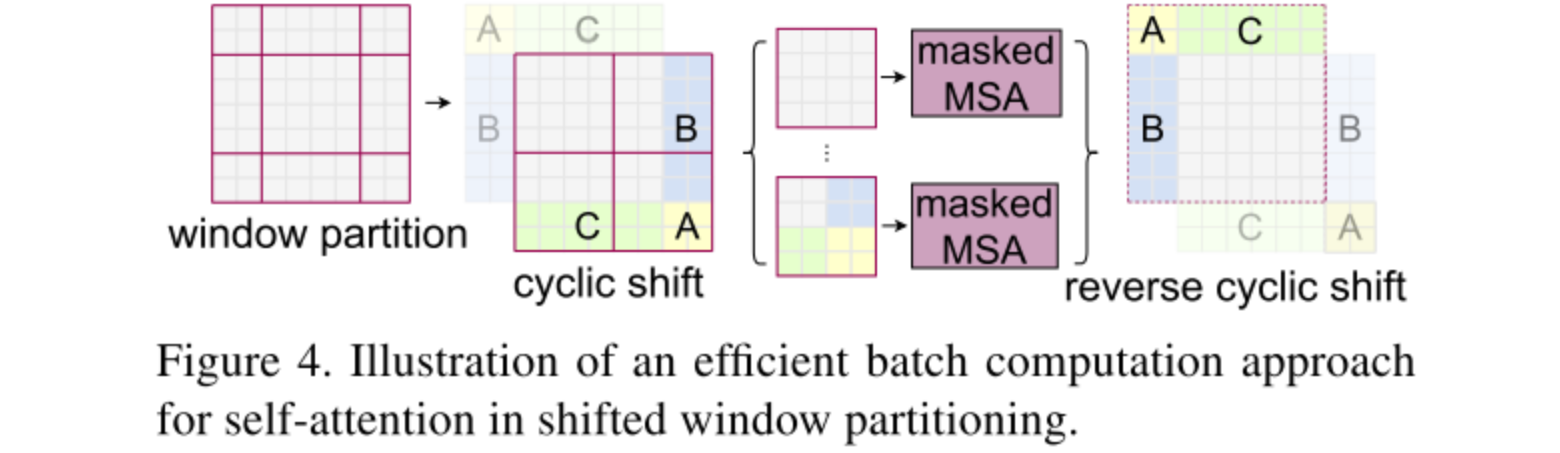

若有padding操作则删去padding。接下来进行drop，并残差链接，通过MLP层后drop，并残差链接。

In [ ]:
class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=(self.window_size, self.window_size), num_heads=num_heads, qkv_bias=qkv_bias,
            attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, attn_mask):
        H, W = self.H, self.W
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # pad feature maps to multiples of window size
        # 把feature map给pad到window size的整数倍
        pad_l = pad_t = 0
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        pad_b = (self.window_size - H % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
        _, Hp, Wp, _ = x.shape

        # cyclic shift
        if self.shift_size > 0:
            # 对H维度从上往下，W维度从左往右进行移动
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # [nW*B, Mh, Mw, C]
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # [nW*B, Mh*Mw, C]

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=attn_mask)  # [nW*B, Mh*Mw, C]

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)  # [nW*B, Mh, Mw, C]
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # [B, H', W', C]

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            # 把前面pad的数据移除掉
            x = x[:, :H, :W, :].contiguous()

        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

# BasicLayer

初始化了众多参数，其中shift_size = $\left\lfloor \frac{window\_size}{2} \right\rfloor$，在SwinTransformerBlock中通过depth判断进行WMSA还是SWMSA，最后依照参数决定是否进行下采样。

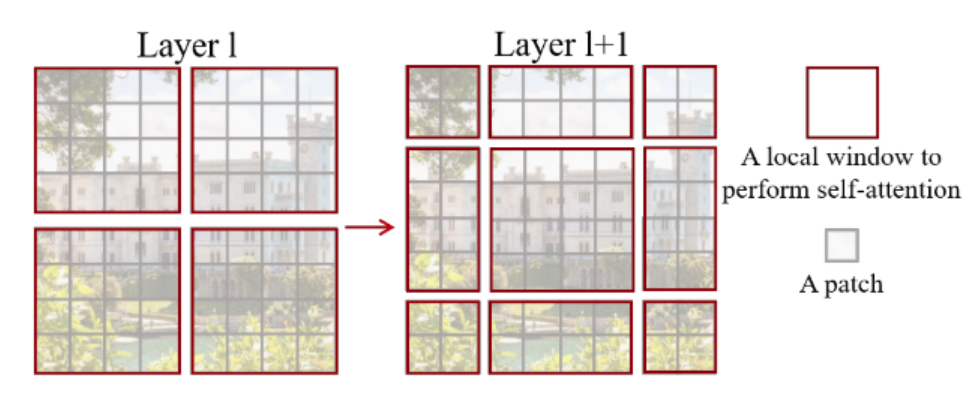

前向传播过程：  

mask生成代码在此处是为了针对多尺度问题，根据传入的xHW生产对应的mask，不会一成不变。之后将其和x传入Swin Transformer Block堆叠depth次，根据downsample参数决定是否进行patch merging

## create_mask 
这是 Swin Transformer 的精华，通过设置合理的 mask，让Shifted Window Attention在与Window Attention相同的窗口个数下，达到等价的计算结果。  

先进行padding，创建于特征图一致的mask，对高宽进行切片，并使用cnt对切片编号->[1, Hp, Wp, 1]  

再使用window_partition根据编号划分窗口->[nW, Mh, Mw, 1]->[nW, Mh*Mw]  

利用广播机制做[nW, 1, Mh\*Mw] - [nW, Mh\*Mw, 1]  

对于mask矩阵中不为0的部分将其设置为-100，后续进行自注意力机制时他们就被掩盖掉了。

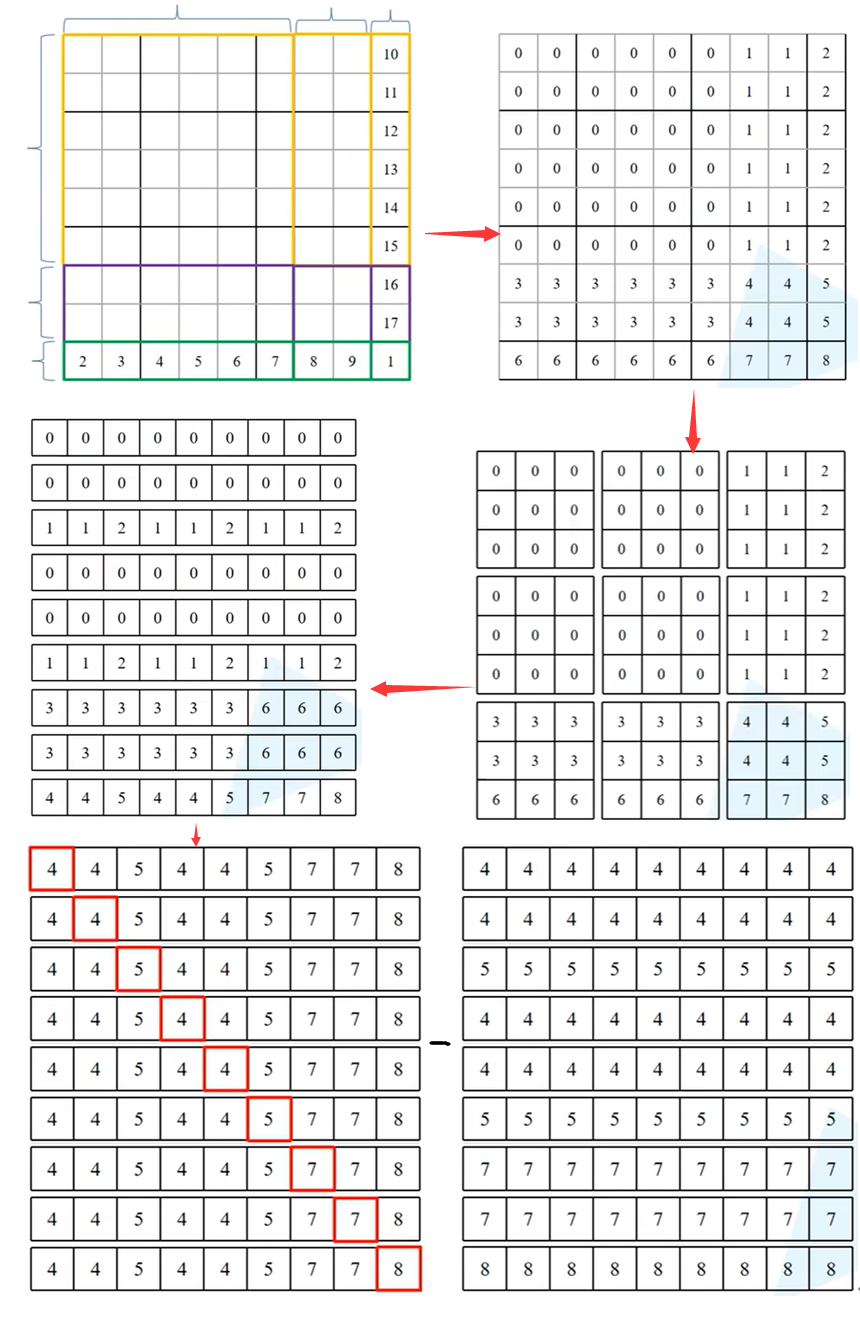

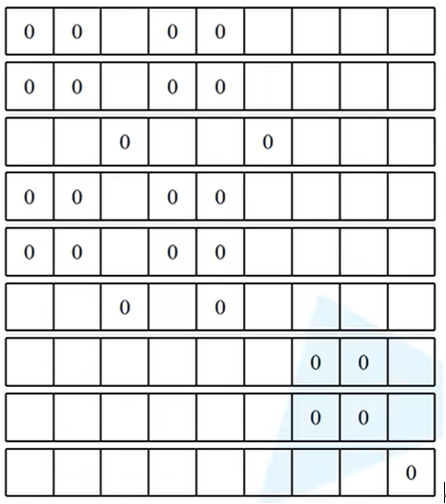

In [ ]:
class BasicLayer(nn.Module):
    """
    A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.window_size = window_size
        self.use_checkpoint = use_checkpoint
        self.shift_size = window_size // 2

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else self.shift_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def create_mask(self, x, H, W):
        # calculate attention mask for SW-MSA
        # 保证Hp(高窗口数)和Wp(宽窗口数)是window_size的整数倍
        Hp = int(np.ceil(H / self.window_size)) * self.window_size
        Wp = int(np.ceil(W / self.window_size)) * self.window_size
        # 拥有和feature map一样的通道排列顺序，方便后续window_partition
        img_mask = torch.zeros((1, Hp, Wp, 1), device=x.device)  # [1, Hp, Wp, 1]
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # [nW, Mh, Mw, 1]
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)  # [nW, Mh*Mw]
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)  # [nW, 1, Mh*Mw] - [nW, Mh*Mw, 1]
        # [nW, Mh*Mw, Mh*Mw]
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        return attn_mask

    def forward(self, x, H, W):
        attn_mask = self.create_mask(x, H, W)  # [nW, Mh*Mw, Mh*Mw]
        for blk in self.blocks:
            blk.H, blk.W = H, W
            if not torch.jit.is_scripting() and self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, attn_mask)
            else:
                x = blk(x, attn_mask)
        if self.downsample is not None:
            x = self.downsample(x, H, W)
            H, W = (H + 1) // 2, (W + 1) // 2

        return x, H, W

# SwinTransformer

定义了众多参数，其中 
- stage4输出特征矩阵的通道数C=$ embed\_dim \times 2^{(self.num\_layers - 1)} $
- 将图像划分为最基本单元的patch_embed
- stochastic depth产生针对每一个SwinTransformer Block所采用的droprate
- stages与原论文有所不同，在微软亚洲研究院提供的代码中，是将Patch Merging作为每个 Stage 最后结束的操作，输入先进行Swin Transformer Block操作，再下采样。而最后一个 Stage 不需要进行下采样操作，之间通过后续的全连接层与 target label 计算损失。
- apply对权重进行初始化

前向传播过程：  

对图像进行patch_embed、dropout，在让其经过众多stages，对其结果进行LN并做一个自适应的全局平均池化层([B, L, C]->[B, C, 1])并展平，最后通过一个全连接层得到输出。

In [ ]:
class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=(2, 2, 6, 2), num_heads=(3, 6, 12, 24),
                 window_size=7, mlp_ratio=4., qkv_bias=True,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        # stage4输出特征矩阵的channels
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            patch_size=patch_size, in_c=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            # 注意这里构建的stage和论文图中有些差异
            # 这里的stage不包含该stage的patch_merging层，包含的是下个stage的
            layers = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                                depth=depths[i_layer],
                                num_heads=num_heads[i_layer],
                                window_size=window_size,
                                mlp_ratio=self.mlp_ratio,
                                qkv_bias=qkv_bias,
                                drop=drop_rate,
                                attn_drop=attn_drop_rate,
                                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                                norm_layer=norm_layer,
                                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                                use_checkpoint=use_checkpoint)
            self.layers.append(layers)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        # x: [B, L, C]
        x, H, W = self.patch_embed(x)
        x = self.pos_drop(x)

        for layer in self.layers:
            x, H, W = layer(x, H, W)

        x = self.norm(x)  # [B, L, C]
        x = self.avgpool(x.transpose(1, 2))  # [B, C, 1]
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x